<a href="https://colab.research.google.com/github/nemanja1995/Deep-Learning/blob/master/Visualizing_convnet_filters_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import keras
keras.__version__
import matplotlib.pyplot as plt
import numpy as np
from keras.applications import VGG16
from keras import backend as K

Using TensorFlow backend.


## Visualizing convnet filters


Another easy thing to do to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond 
to. This can be done with __gradient ascent in input space__: applying __gradient descent__ to the value of the input image of a convnet so 
as to maximize the response of a specific filter, starting from a blank input image. The resulting input image would be one that the chosen 
filter is maximally responsive to.

The process is simple: we will build a loss function that maximizes the value of a given filter in a given convolution layer, then we 
will use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. For instance, here's 
a loss for the activation of filter 0 in the layer "block3_conv1" of the VGG16 network, pre-trained on ImageNet:

In [3]:
model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step


To implement gradient descent, we will need the gradient of this loss with respect to the model's input. To do this, we will use the 
`gradients` function packaged with the `backend` module of Keras:

The resulting image tensor will be a floating point tensor of shape `(1, 150, 150, 3)`, with values that may not be integer within `[0, 
255]`. Hence we would need to post-process this tensor to turn it into a displayable image. We do it with the following straightforward 
utility function:

In [0]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Now we have all the pieces, let's put them together into a Python function that takes as input a layer name and a filter index, and that 
returns a valid image tensor representing the pattern that maximizes the activation the specified filter:

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

It seems that filter 0 in layer `block3_conv1` is responsive to a polka dot pattern.

Now the fun part: we can start visualising every single filter in every layer. For simplicity, we will only look at the first 64 filters in 
each layer, and will only look at the first layer of each convolution block (block1_conv1, block2_conv1, block3_conv1, block4_conv1, 
block5_conv1). We will arrange the outputs on a 8x8 grid of 64x64 filter patterns, with some black margins between each filter pattern.

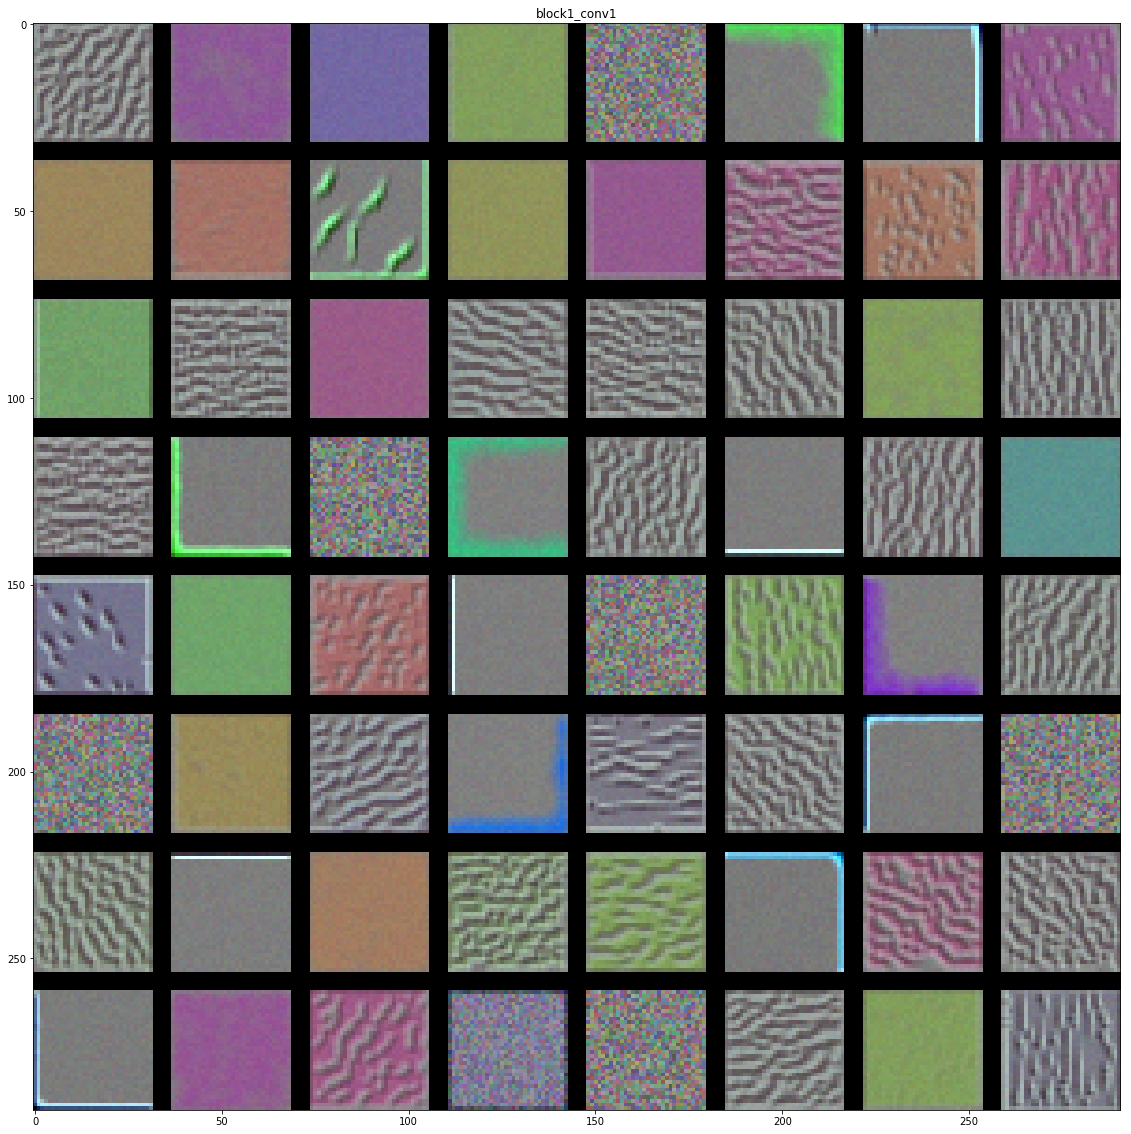

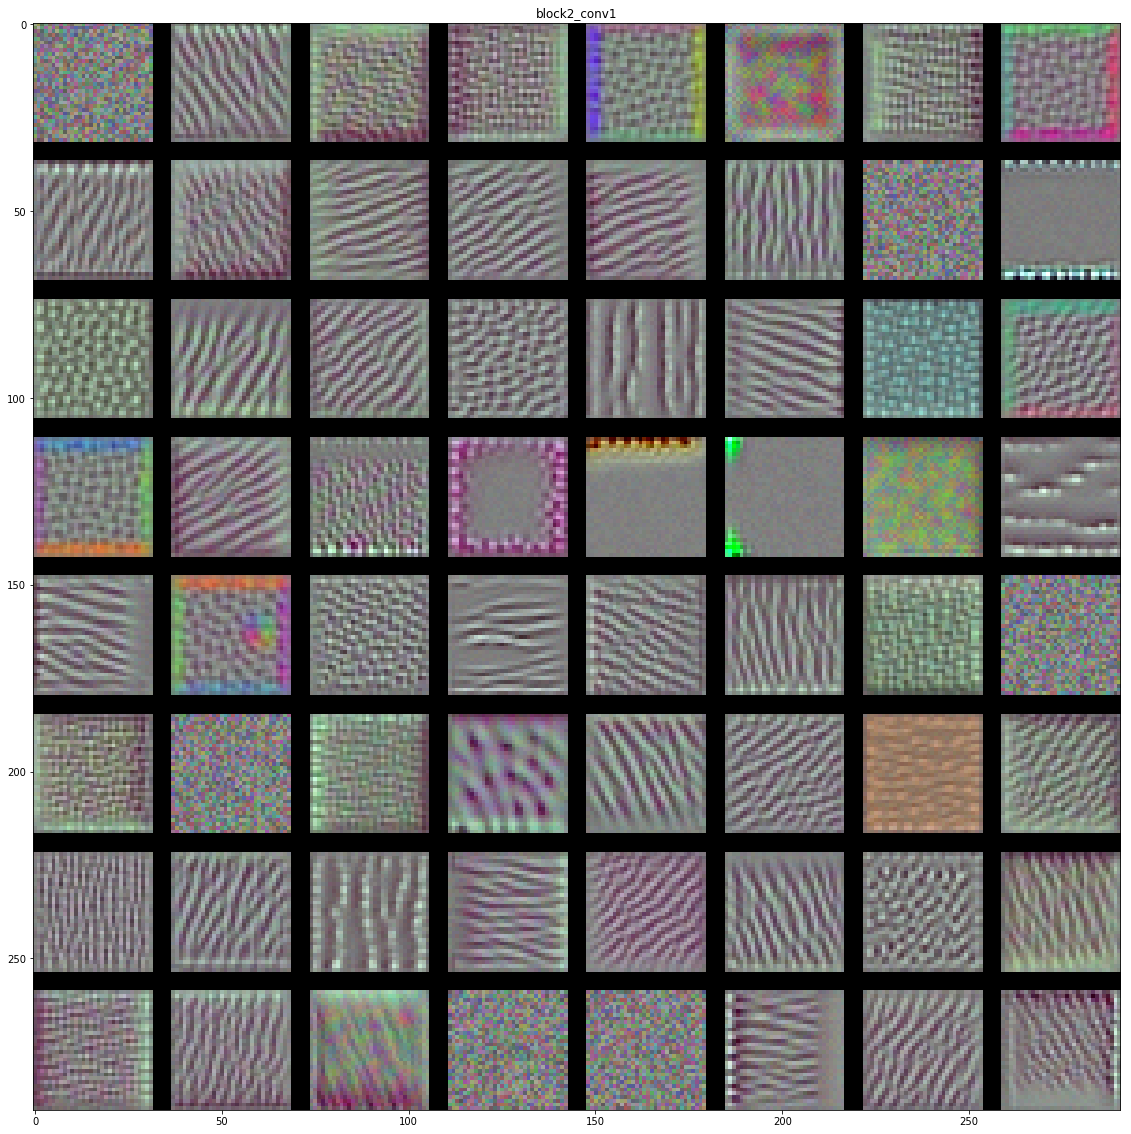

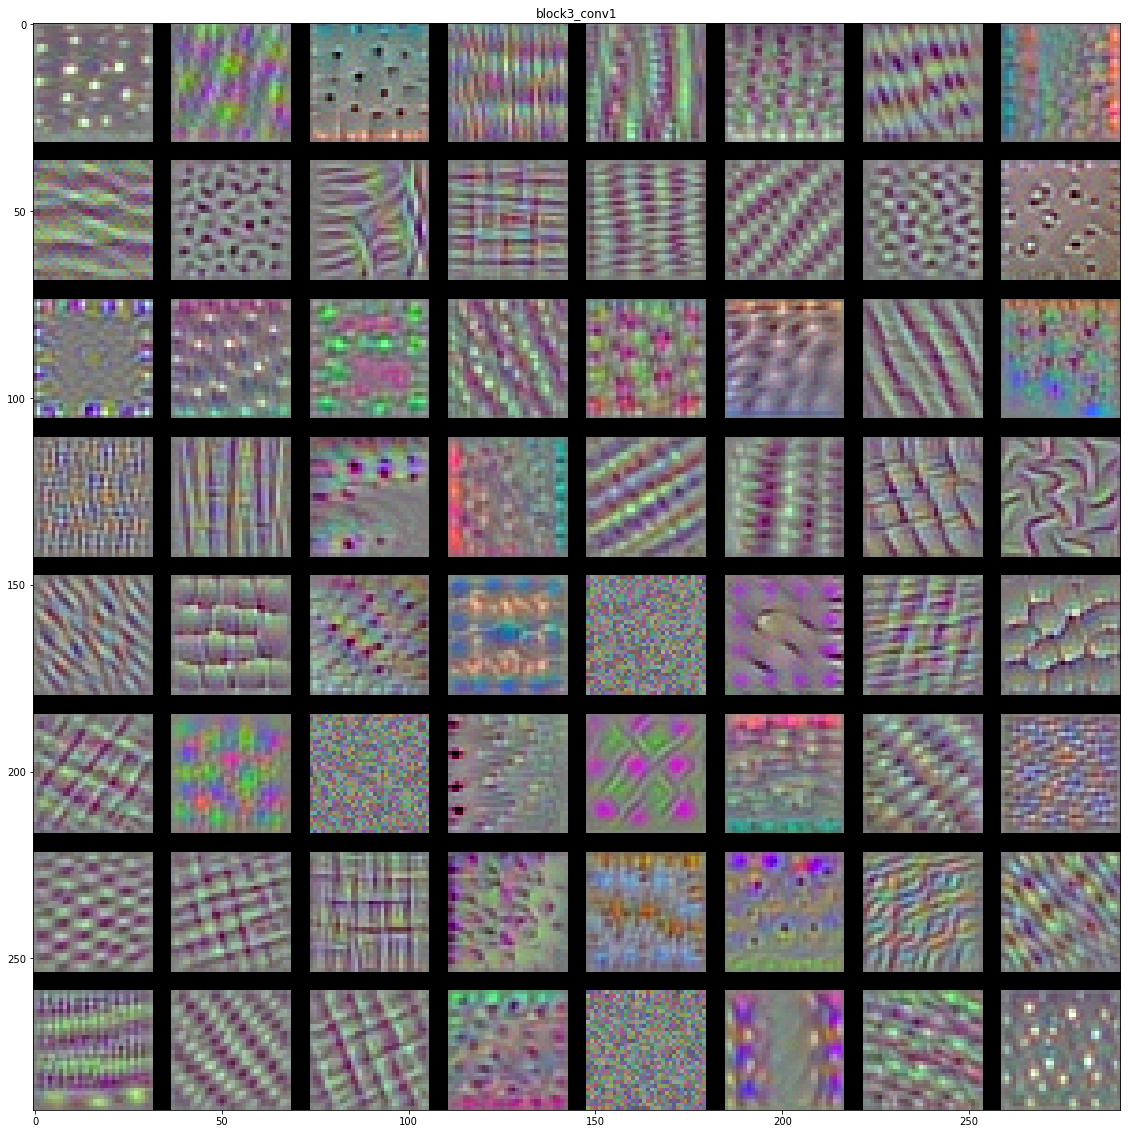

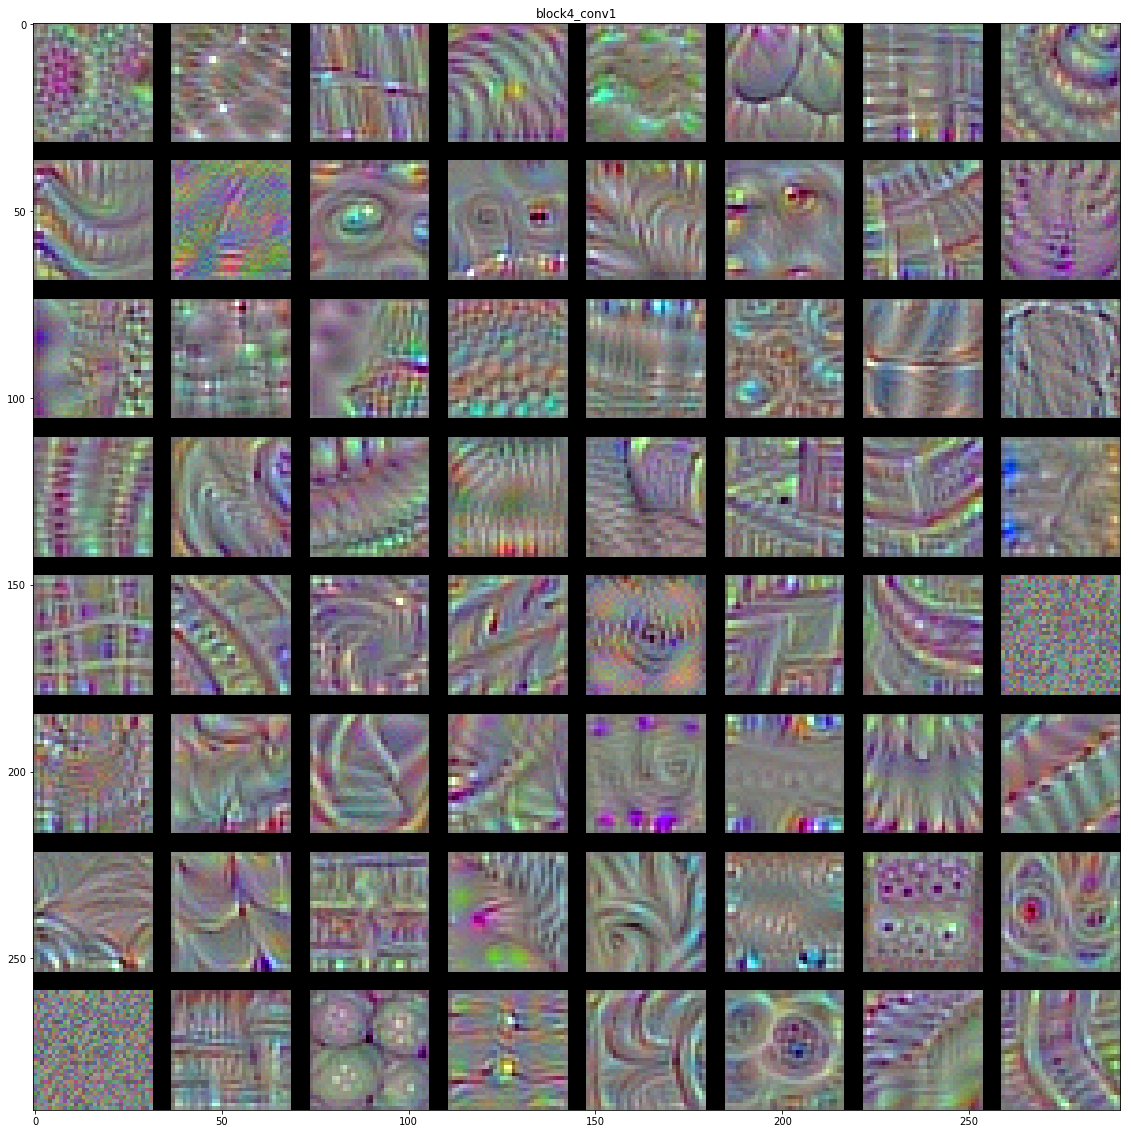

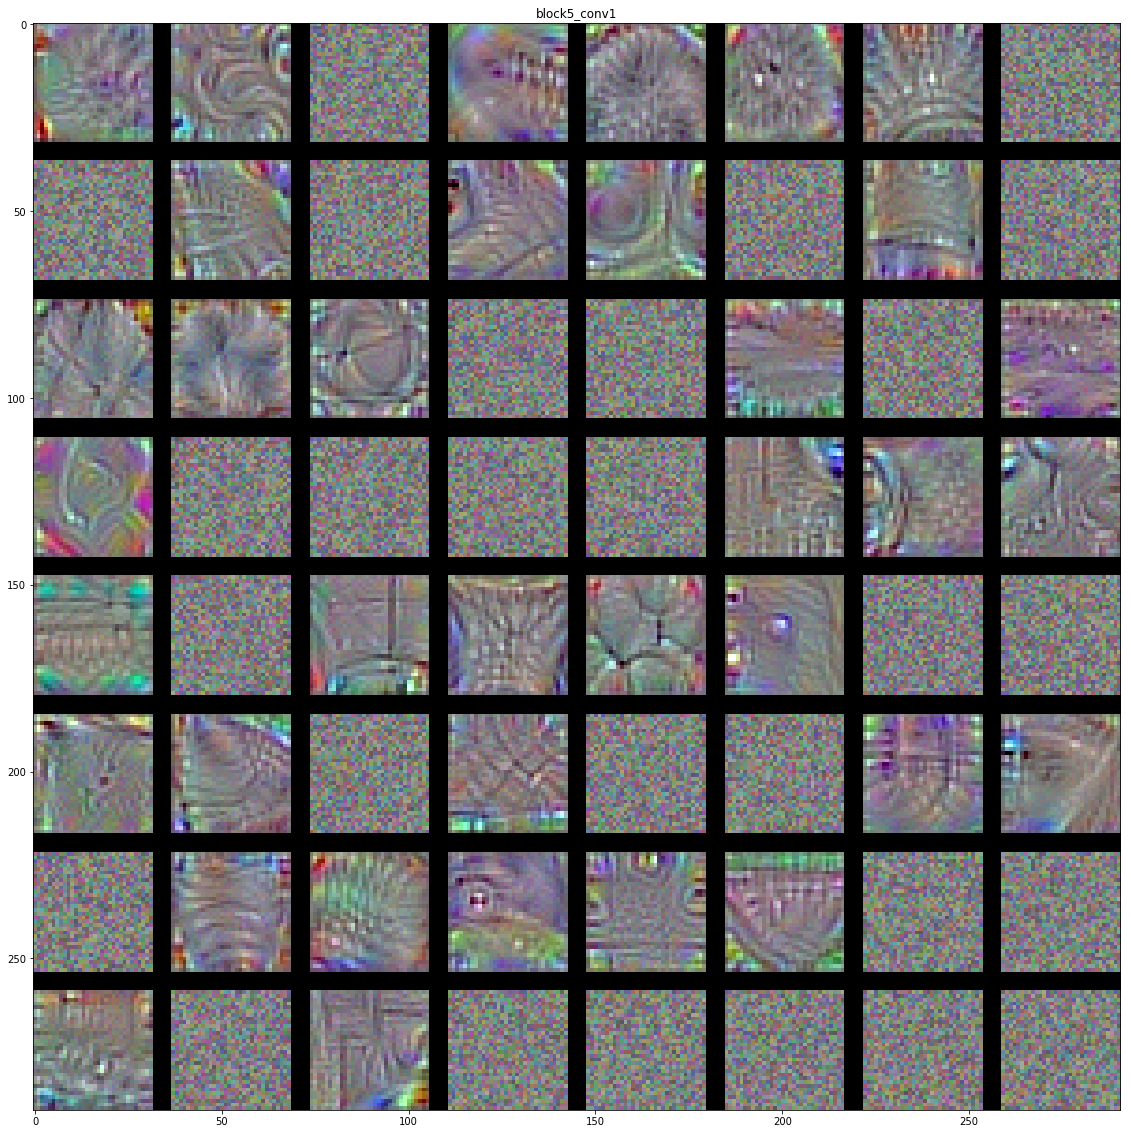

In [8]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']:
    size = 32
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            #plt.imshow(filter_img)
            #plt.show()

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img/255

    # Display the results grid
    
    plt.figure(figsize=(20, 20))
    plt.title(layer_name)
    plt.imshow(results)
    plt.show()

These filter visualizations tell us a lot about how convnet layers see the world: each layer in a convnet simply learns a collection of 
filters such that their inputs can be expressed as a combination of the filters. This is similar to how the Fourier transform decomposes 
signals onto a bank of cosine functions. The filters in these convnet filter banks get increasingly complex and refined as we go higher-up 
in the model:

* The filters from the first layer in the model (`block1_conv1`) encode simple directional edges and colors (or colored edges in some 
cases).
* The filters from `block2_conv1` encode simple textures made from combinations of edges and colors.
* The filters in higher-up layers start resembling textures found in natural images: feathers, eyes, leaves, etc.